# Time Series Tutorial

In this tutorial we are going to cover most basic aspects of **Time Series Analysis**, learning how to *manipulate time series data* with **pandas** and *make predictions*. We are going to especially *emphasize* on **Feature Engineering.**<br>
Although most things are explained, some familiarity with **pandas** will be very useful in order to follow the tutorial easily.

## 1. Basics

### What is a Time Series?
A *time series* is a **sequence of observations** recorded at regular time intervals.<br>
Depending on the **frequency** of observations, a time series may be *hourly, daily, weekly, monthly, quarterly and annual* (for example, monthly sales). Sometimes, you might have *seconds and minute-wise* time series as well (for example, clicks per minute).

**Unlike random sample data, it can contain additional information due to its deterministic nature.**

Let's have a look at our data. First, we are going to import needed libraries.

In [3]:
import warnings
warnings.filterwarnings("ignore")                    #ignore warnings
import time

import numpy as np                                   #basic data science libraries
import pandas as pd

import matplotlib.pyplot as plt                      #visualization
from pylab import rcParams
plt.rc('figure', figsize=(15, 8), titlesize=16)
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

import statsmodels.api as sm                         #some useful models
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error       #metrics
from sklearn.metrics import mean_absolute_error

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Data

We will analyze **2 different datasets**.<br>
The first one contains the minimum daily *temperatures over 10 years* (1981-1990) in Melbourne, Australia in degrees Celsius.

In [5]:
dataset1 = pd.read_csv("daily-min-temperatures.csv")
print(dataset1.shape)
dataset1.head()

(3650, 2)


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


The second one contains *sales records* for a store from 2014 to 2017.

In [6]:
dataset2 = pd.read_excel("Superstore.xls")
print(dataset2.shape)
dataset2.head()

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


While the first dataset is a pretty **straightforward time series**, the second one is more complex and will require some **preprocessing** in order to become a clear time series.

### Preprocessing

In [7]:
dataset2["Category"].nunique()

3

As we can see, sales data range in *3 different categories* (Furniture, Office Supplies and Technology).<br>
We could make a **single time series** out of all sales, but to simplify things and be able to apply our **domain knowledge**, we will work with the data in the **Office Supplies** category.

In [8]:
office = dataset2.loc[dataset2['Category'] == 'Office Supplies']
office.shape

(6026, 21)

The first step in order to create a time series from this dataset is to **remove all columns** except the date and the value of sales.

In [9]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
office.drop(cols, axis=1, inplace=True)
office = office.sort_values('Order Date')

In [10]:
office.head()

,Order Date,Sales
7980,2014-01-03,16.448
740,2014-01-04,272.736
739,2014-01-04,11.784
741,2014-01-04,3.540
1759,2014-01-05,19.536


As we can see, *each day can have more than one sale*. In order to create a daily time series, we are going to **group the data** by adding all sales for each day and use the date as an index.

In [11]:
office = office.groupby('Order Date')['Sales'].sum().reset_index()
office = office.set_index('Order Date')
office.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,685.340
2014-01-07,10.430


As our current daily series **can be tricky** to work with, we can **transform it** to a monthly one. This depends as much on the data as on the final **prediction goal** (if it is required to predict the sales over a month or on a certain day etc.)<br>
We will use the **average of daily values** for each month, and the **start of each month as the timestamp**. <br>
`pandas.resample` will do the work easily.

In [12]:
office = office['Sales'].resample('MS').mean()     #https://stackoverflow.com/questions/17001389/pandas-resample-documentation
print(office.shape[0])
office.head()

48


Order Date
2014-01-01    285.357647
2014-02-01     63.042588
2014-03-01    391.176318
2014-04-01    464.794750
2014-05-01    324.346545
Freq: MS, Name: Sales, dtype: float64

Did you notice anything? `pd.resample().mean()` converted the `pd.Dataframe` object into a `pd.Series` object.

In [13]:
isinstance(office, pd.Series)

True

A **Series** is a **one-dimensional object** that can hold any data type such as integers, floats and strings. A Series object is very **similar to a Dataframe**, but it is more **useful when having** to deal with timeseries data.<br>
We will see more about Series later on.

### Visualization

We will now use **matplotlib** in order to plot our two timeseries.

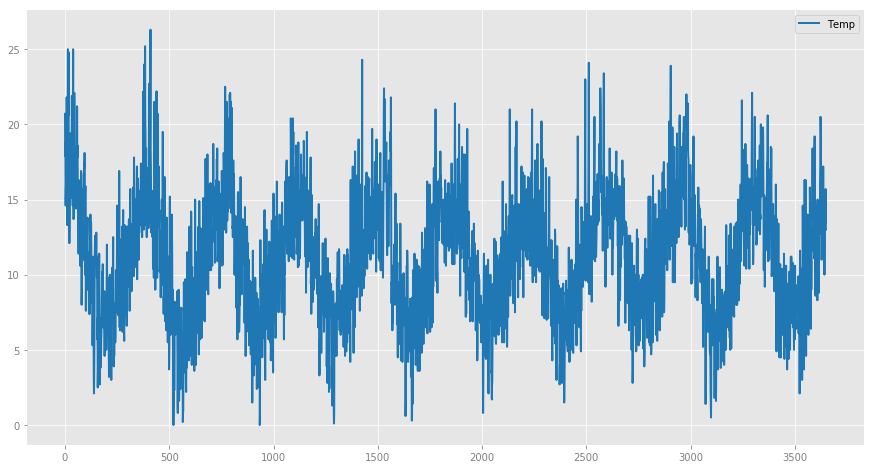

In [14]:
dataset1.plot()
plt.show()

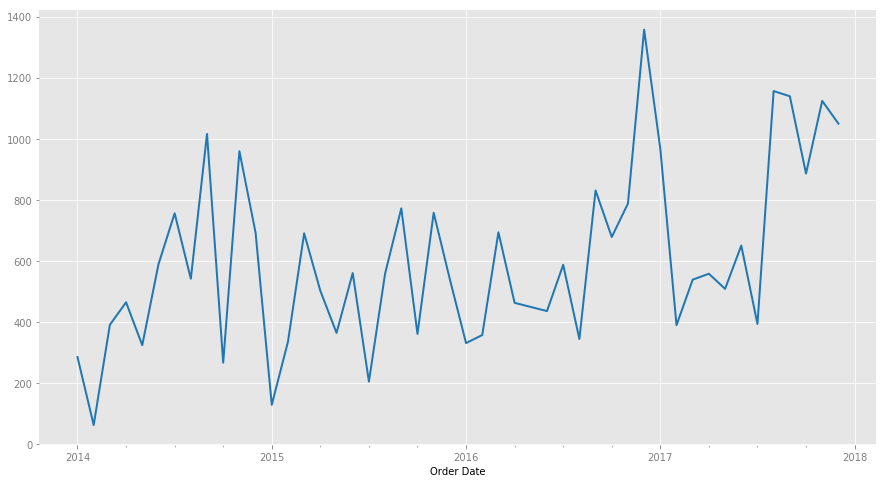

In [15]:
office.plot()
plt.show()

## 2. Modeling

### Series Deconstruction

There are many ways to mathematically model a time series. A simple one can be **splitting the series into the following components**:<br>
```
Base Level - Trend - Seasonality - Error
```
These components can be **combined in either of two ways**:

Additive time series:<br>
```
Value = Base Level + Trend + Seasonality + Error
```

Multiplicative Time Series:<br>
```
Value = Base Level x Trend x Seasonality x Error
```

**Trend**: It is observed when there is an **overally** increasing or decreasing slope observed in the time series.<br>
**Seasonality**: It is observed when there is a **distinct repeated pattern** observed between regular intervals due to seasonal factors.<br>

In [16]:
result_mul = sm.tsa.seasonal_decompose(office, model='multiplicative')
result_add = sm.tsa.seasonal_decompose(office, model='additive')

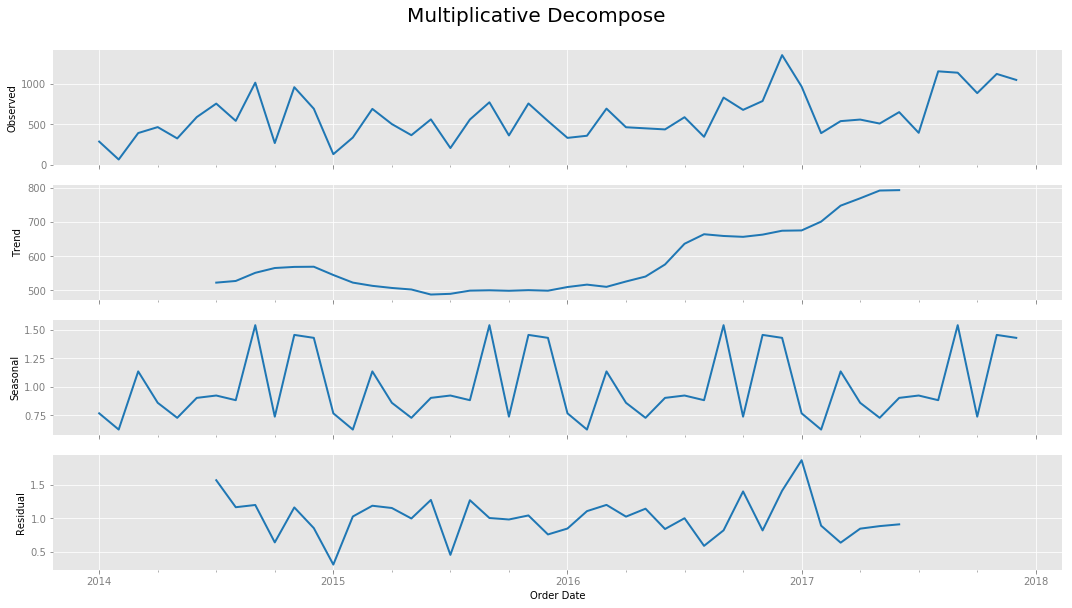

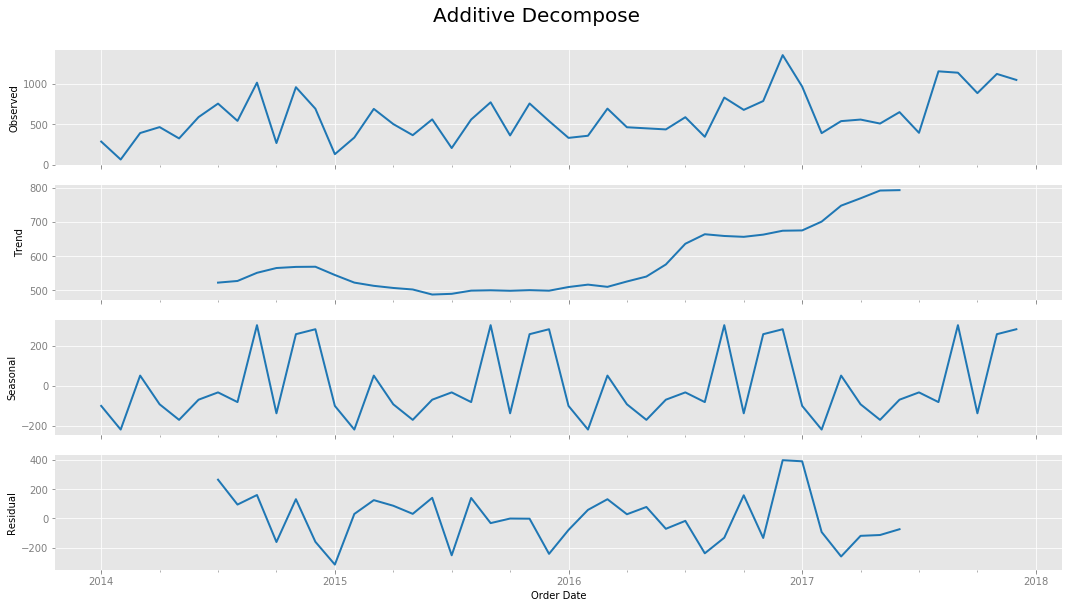

In [17]:
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20, y = 1.05)
result_add.plot().suptitle('Additive Decompose', fontsize=20, y = 1.05)
plt.show()

We can see that in this case, the two models produce *almost identical* components.

### Stationarity

**Stationarity** is a property of a time series. A stationary series is one where **the values of the series is not a function of time**.<br>
That is, the **statistical properties** of the series like mean, variance and autocorrelation are **constant over time**.<br>
This means that **White Noise** is a prime example of a stationary series.
A stationary time series is **devoid of seasonal effects** as well.

<img src="img/stationary-and-non-stationary-time-series.png">

The stationarity of a series can be **established by looking at the plot** of the series, but there are also **quantitative tests**.<br>
The most famous is the **ADF test** (Augmented Dickey-Fuller test), in which the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the p-Value in ADF test is less than the significance level (0.05), you reject the null hypothesis.

In [18]:
def decompose(df):
    result = sm.tsa.seasonal_decompose(df, model='additive')
    result.plot().suptitle('Additive Decompose', fontsize=20, y = 1.05)
    plt.show()

In [19]:
def adf(df):
    
    # ADF Test
    result = sm.tsa.stattools.adfuller(df.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
    
    #plotting components
    decompose(df)

ADF Statistic: -4.664633175077928
p-value: 9.801371572373162e-05
Critical Values:
   1%, -3.5778480370438146
Critical Values:
   5%, -2.925338105429433
Critical Values:
   10%, -2.6007735310095064


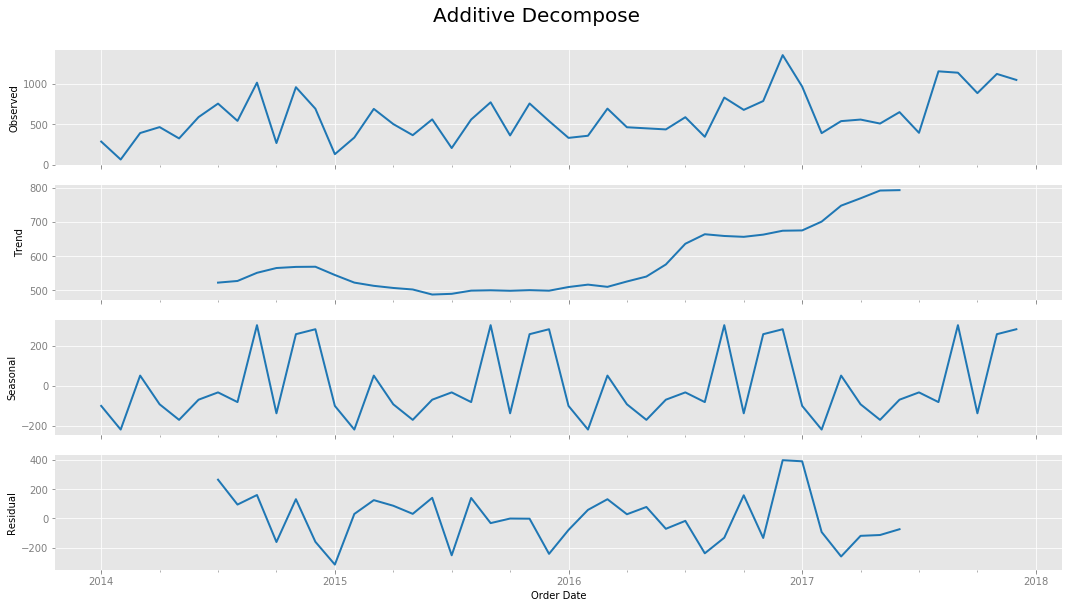

In [20]:
adf(office)

This means we can safely **reject the null hypothesis**, so the series is **stationary**.<br>
However, we **need to take care of the seasonality pattern** before having a fully stationary series.

As we can see from the above plots, the **seasonality pattern repeats** every year, or 12 months. In order to **cancel that effect**, we can **subtract the series from itself** with a **lag** that equals the seasonal period.

ADF Statistic: -5.19119007092499
p-value: 9.163597811282995e-06
Critical Values:
   1%, -3.6327426647230316
Critical Values:
   5%, -2.9485102040816327
Critical Values:
   10%, -2.6130173469387756


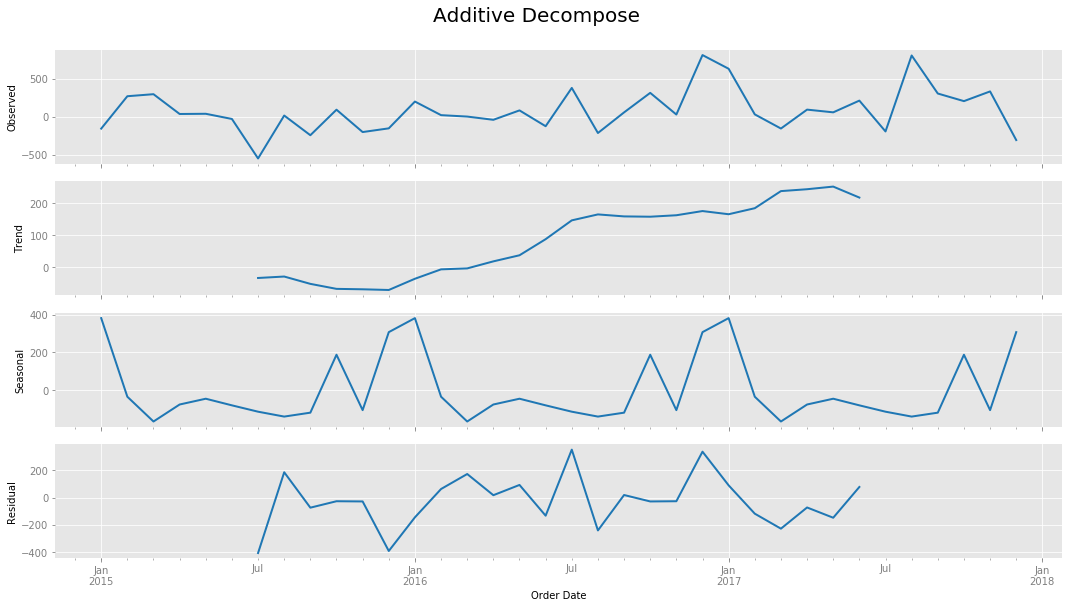

In [21]:
office_dif = office - office.shift(12)
adf(office_dif[12:])

We can now see that *the series looks* (and indeed is as we can see with the ADF test) *more stationary* and the seasonal component is not as prevalent.<br>
In order to **improve the stationarity**, we will calculate the **first order differences** (subtract the series from itself with a lag of 1).

ADF Statistic: -6.391690359679094
p-value: 2.098283123843644e-08
Critical Values:
   1%, -3.6461350877925254
Critical Values:
   5%, -2.954126991123355
Critical Values:
   10%, -2.6159676124885216


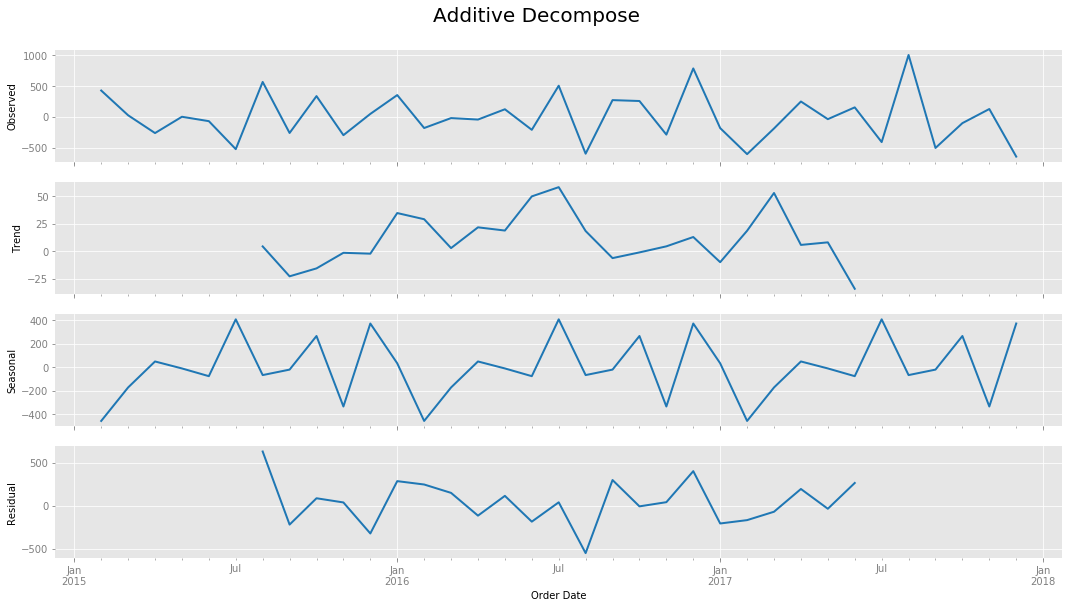

In [22]:
office_dif1 = office_dif - office_dif.shift(1)
adf(office_dif1[13:])

This has improved even more our results. Let's **try with second order differences**.

ADF Statistic: -6.088651683577466
p-value: 1.0493903227904706e-07
Critical Values:
   1%, -3.653519805908203
Critical Values:
   5%, -2.9572185644531253
Critical Values:
   10%, -2.6175881640625


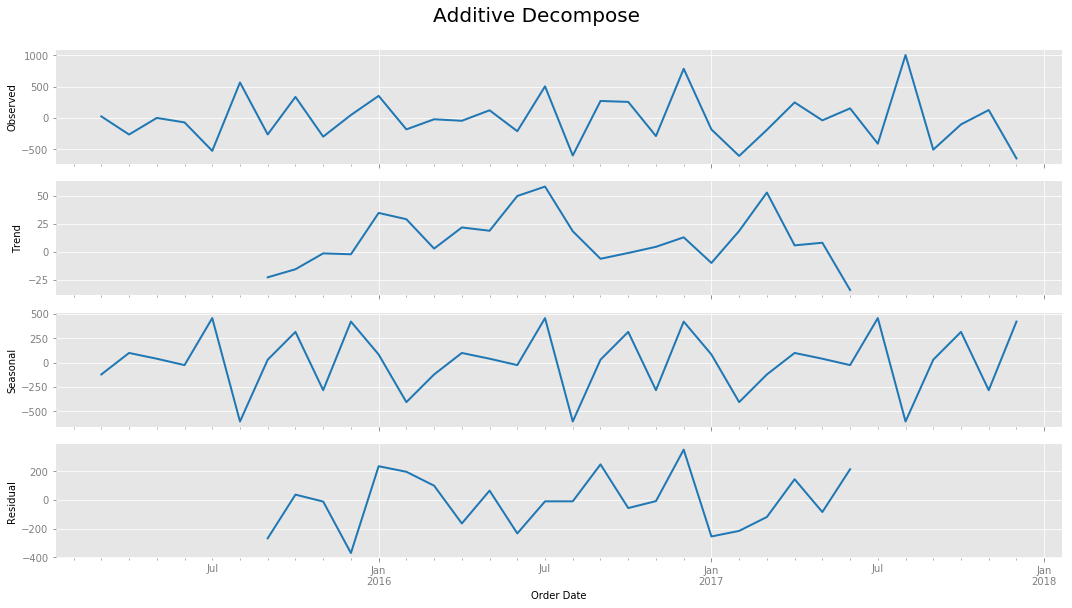

In [23]:
office_dif2 = office_dif1 - office_dif1.shift(1)
adf(office_dif1[14:])

This time a *stronger seasonal component appeared*, so we will stick with first order differences.

#### Why is stationarity so important? 
Because it is **easy to make predictions** on a stationary series since we can **assume that the future statistical properties will not be different from those currently observed**. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example).<br>

## 3. Forecasting (ARIMA models) *

Although ARIMA models are widely used, this tutorial focuses on other forecasting methods, so we will just shortly present them for the sake of completeness.<br>
More on building ARIMA models:
- https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

One of the most *commonly used method* for time-series forecasting is known as **ARIMA**, which stands for **Autoregressive Integrated Moving Average**.<br>
ARIMA models are denoted with the **notation ARIMA(p, d, q)**. These three parameters account for seasonality, trend, and noise in data.<br>
There are many variations. We will use one of them noted **SARIMA(p, d, q) x (P, D, Q, s).**, standing for **Seasonal ARIMA**.

**(!) Note: A series must be stationary in order to use an ARIMA model**

### Finding the Best Parameters

We will use the following code to estimate the parameters. Note that this can be an **extremely time consuming process** (for only 5 different values, we get 625 different combinations, the 4th power of the number of possible values).

In [24]:
import itertools

# setting initial values and some bounds for them
ps = range(0, 5)
d = 1 #order of differences used to achieve stationarity
qs = range(0, 5)
Ps = range(0, 5)
D = 1 #order of differences used to achieve stationarity
Qs = range(0, 5)
s = 12 # season length

# creating list with all the possible combinations of parameters
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [25]:
def optimizeSARIMA(data, parameters_list, d, D, s):
    results = []
    best_aic = float("inf")
    
    #going through every possible combination
    for param in parameters_list:
        try:
            model = sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        
        #storing the best
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [26]:
result_table = optimizeSARIMA(office, parameters_list, d, D, s)
result_table.head()

,parameters,aic
0,"(0, 1, 1, 0)",497.515178
1,"(0, 1, 2, 0)",498.251114
2,"(4, 2, 1, 0)",498.261320
3,"(1, 1, 1, 0)",498.788065
4,"(0, 2, 1, 0)",498.845590


The **best set of parameters** is the one with the **lowest aic**, so we create the model and make a prediction.

In [27]:
p, q, P, Q = result_table.parameters[0]

### Predicting

In [28]:
best_model = sm.tsa.statespace.SARIMAX(office, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [29]:
office = office.to_frame()
office = office.rename({'Sales':'actual'}, axis=1)

In [30]:
office['model'] = best_model.fittedvalues
office['model'][:s+d] = np.NaN
office.head(15)

,actual,model
Order Date,,
2014-01-01,285.357647,NaN
2014-02-01,63.042588,NaN
2014-03-01,391.176318,NaN
2014-04-01,464.794750,NaN
2014-05-01,324.346545,NaN
2014-06-01,588.774409,NaN
2014-07-01,756.060400,NaN
2014-08-01,541.879143,NaN
2014-09-01,1015.677704,NaN


In [31]:
forecast = best_model.predict(start = office.shape[0], end = office.shape[0]+12) #predictions for 12 months
forecast = office.model.append(forecast)

In [32]:
rmse = np.sqrt(mean_squared_error(office['actual'][s+d:], office['model'][s+d:]))
print("Root Mean Square Error: {0:.2f}".format(rmse))
mae = mean_absolute_error(office['actual'][s+d:], office['model'][s+d:])
print("Mean Absolute Error: {0:.2f}".format(mae))
mape = mean_absolute_percentage_error(office['actual'][s+d:], office['model'][s+d:])
print("Mean Absolute Percentage Error: {0:.2f}%".format(mape))

Root Mean Square Error: 266.28
Mean Absolute Error: 200.17
Mean Absolute Percentage Error: 38.65%


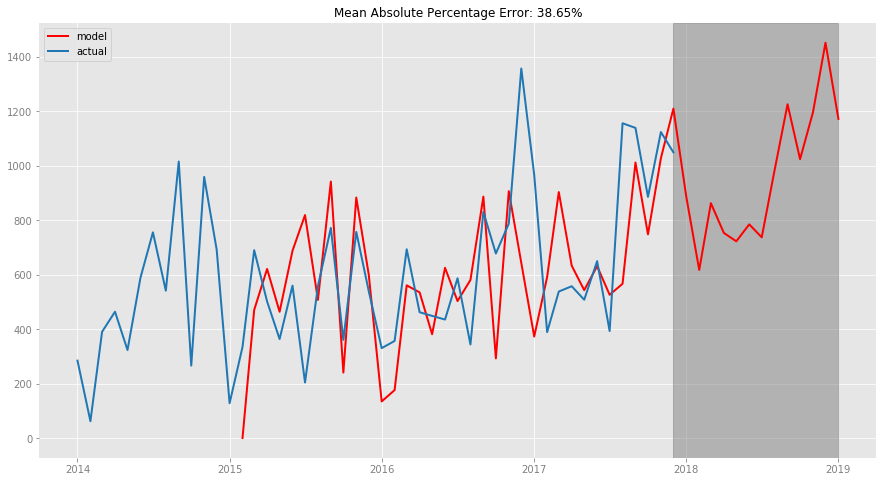

In [33]:
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(mape))
plt.plot(forecast, color='r', label="model")
plt.axvspan(office.index[-1], forecast.index[-1], alpha=0.5, color='gray')
plt.plot(office.actual, label="actual")
plt.legend()
plt.grid(True);

As we can see, our predictions had an error of almost 39%. This is kinda absurd, as **most of the time** ARIMA methods can have **extremely good accuracy**. In our case, a few possible causes can be:
- Very short parameter list
- Not enough stationarity
- Not enough data
- Incompatibility of our data with these methods

In most cases, despite the fact that the accuracy can be very good, they **require a lot of data** in order to produce a decent result.<br>
In addition, the **time needed to prepare the data** (making the series stationary) and finding the optimal parameters might not be worth this accuracy.

## 4. Feature Engineering

In order to use **simple machine learning algorithms** (like *linear regression*) instead of more complex time-series-specific models (like ARIMA) with a time series, we first need to reframe the problem.<br>
Time series data is of the form
```
time 1, value 1
time 2, value 2
time 3, value 3
```
and in order to use supervised learning methods we need to transform it into
```
input 1, output 1
input 2, output 2
input 3, output 3
```
Because input variables in supervised learning are called features, the problem is also framed as
```
feature 11, feature 12, ... output 1
feature 21, feature 22, ... output 2
feature 31, feature 32, ... output 3
```

### Goal
The general **goal of feature engineering** to provide strong (and ideally simple) **relationships between new input features and the output feature** for the supervised learning algorithm we want to model.
In the case of time series, we even need to **invent the input and output** and frame the supervised learning problem from scratch. The difficulty is that we do not know the underlying inherent functional relationship between inputs and outputs that we’re trying to expose. 
Instead, **the only feedback we have is the performance of models** developed on the supervised learning datasets (different “views” of the problem we create).

### Preprocessing

We will work on the *temperature dataset*, and we will work with it both as a Dataframe and a Series object.

In [34]:
temp_df = dataset1.copy()
temp_df = temp_df.set_index('Date')

temp_series = pd.Series.from_csv('daily-min-temperatures.csv', header=0)

We will also need to **set the frequency** for the Series object and fill any **missing values**.

In [35]:
temp_series = temp_series.asfreq('D')
temp_series.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3652, freq='D')

In [36]:
temp_series[temp_series.isna()]

Date
1984-12-31   NaN
1988-12-31   NaN
Name: Temp, dtype: float64

In [37]:
temp_series = temp_series.fillna(method='ffill')

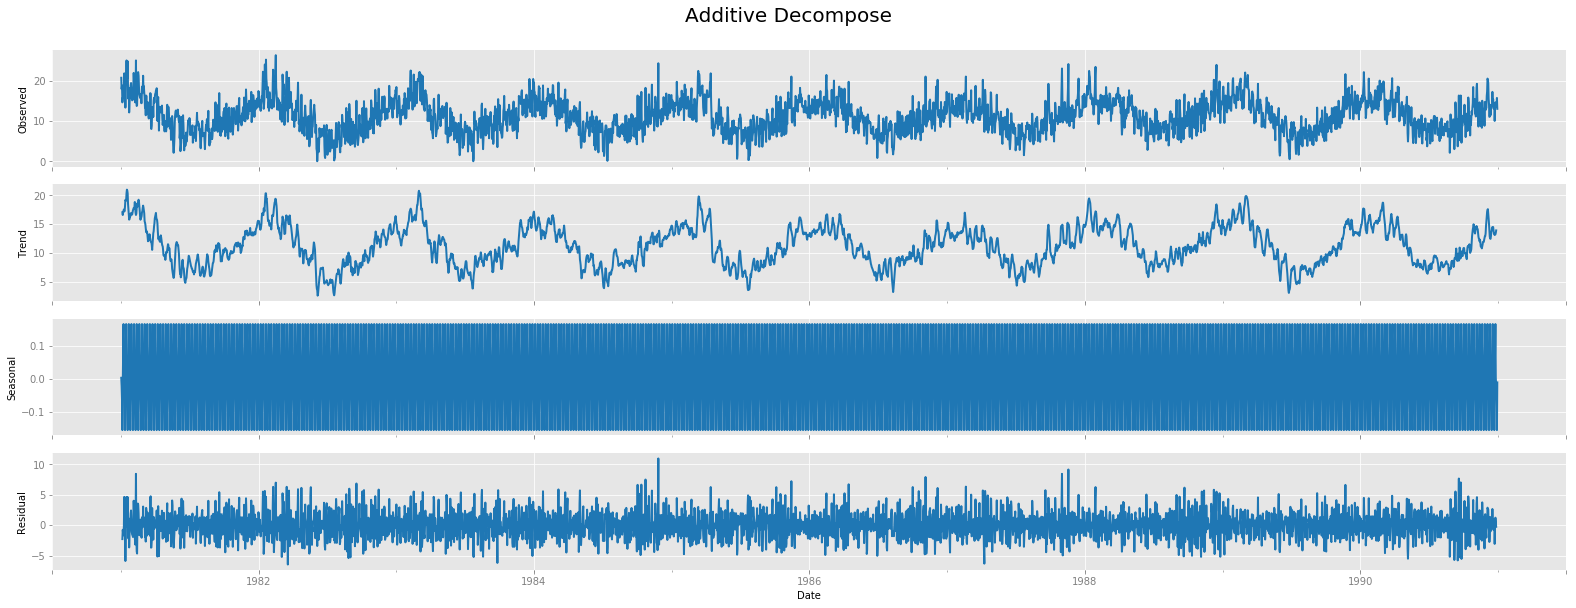

In [38]:
plt.rcParams['figure.figsize'] = [22, 8]
decompose(temp_series)

The *seasonality pattern is negligible* (only 0.15 degrees). Let's try with months.

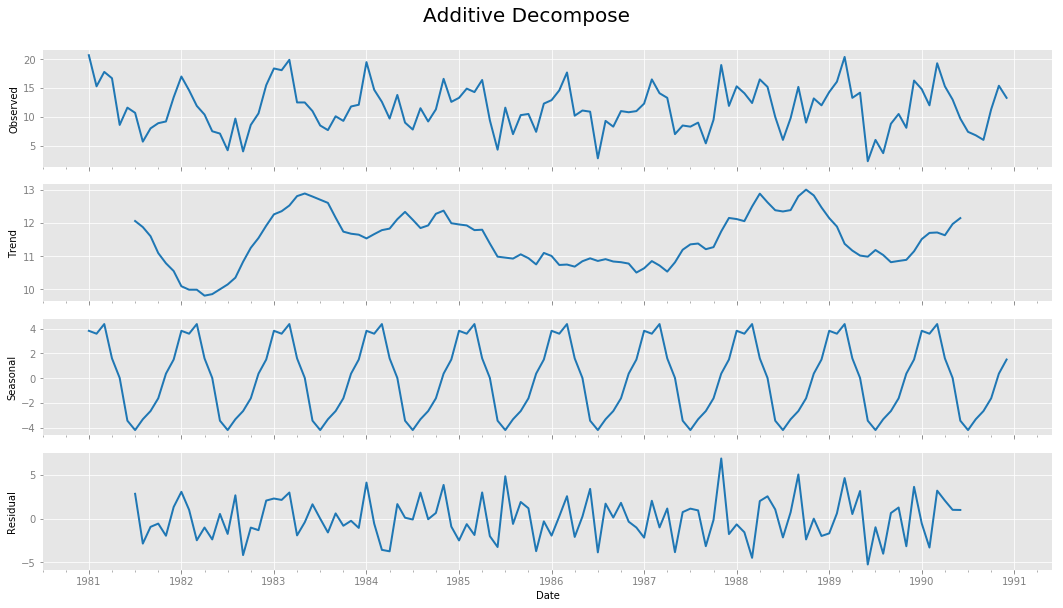

In [39]:
plt.rcParams['figure.figsize'] = [15, 8]
temp_series_m = temp_series.asfreq('MS')
decompose(temp_series_m)

### Model
In order to be able to **evaluate the performance** of different Feature Engineering methods, we will use the **same model** for every one of them.

In [40]:
lr = LinearRegression()

In [41]:
def timeseries_train_test_split(X, y, test_size):
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [42]:
def machine_learning(model, X, y):
    
    #splitting the dataset
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
    
    #making predictions
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    #calculating error
    error = mean_absolute_percentage_error(prediction, y_test)
    
    #plotting the result
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "r", label="prediction", linewidth=1.5)
    
    plt.title("Mean absolute percentage error {0:.15f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

### Feature Engineering Methods
Although there are many techniques for **extracting features** out of a time series, we will discuss 3 ways of approaching this problem, *Date Time Features, Lag Features and Window Features*.

### Date Time Features

These are **features from the date/time of each observation**. In fact, they can start off simply and head off into quite complex domain-specific areas.

Two features that we can **start with** are the **integer month and day** for each observation. We can imagine that supervised learning algorithms may be able to use these inputs to help tease out time-of-year or time-of-month type seasonality information.

In other words, we propose a simple model like this:
```
input       output
-----------------------
Month, Day  Temperature
Month, Day  Temperature
Month, Day  Temperature
```

This can be done with pandas:

In [43]:
dataframe1 = pd.DataFrame()
dataframe1['month'] = [temp_series.index[i].month for i in range(len(temp_series))]
dataframe1['day'] = [temp_series.index[i].day for i in range(len(temp_series))]
dataframe1['temperature'] = [temp_series[i] for i in range(len(temp_series))]

dataframe1.head()

,month,day,temperature
0,1,1,20.7
1,1,2,17.9
2,1,3,18.8
3,1,4,14.6
4,1,5,15.8


This is a very simple model and **will likely result to bad predictions**.

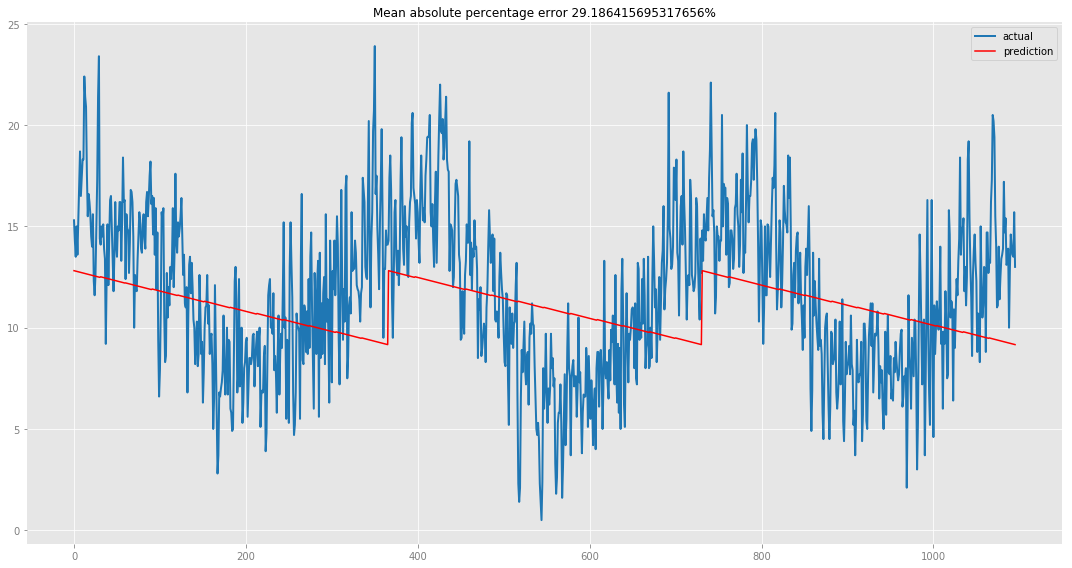

In [44]:
y = dataframe1.temperature
X = dataframe1.drop(['temperature'], axis=1)

machine_learning(lr, X,y)

As expected, the simplicity of the model was detrimental to its accuracy. Nevertheless, this information **coupled with additional engineered features** may ultimately result in a better model.<br>
In the case of our minimum temperature dataset, maybe the *information about the season* would be more relevant.<br>
It is creating **domain-specific features** like this that are more likely to add value to your model.

In [45]:
dataframe1['season'] = [1 if (temp_series.index[i].month == 1 or temp_series.index[i].month == 2 or temp_series.index[i].month == 12) else 2 if (temp_series.index[i].month >= 3 and temp_series.index[i].month <=5) else 3 if (temp_series.index[i].month >= 6 and temp_series.index[i].month <=8) else 4 for i in range(len(temp_series))]

dataframe1.head()

,month,day,temperature,season
0,1,1,20.7,1
1,1,2,17.9,1
2,1,3,18.8,1
3,1,4,14.6,1
4,1,5,15.8,1


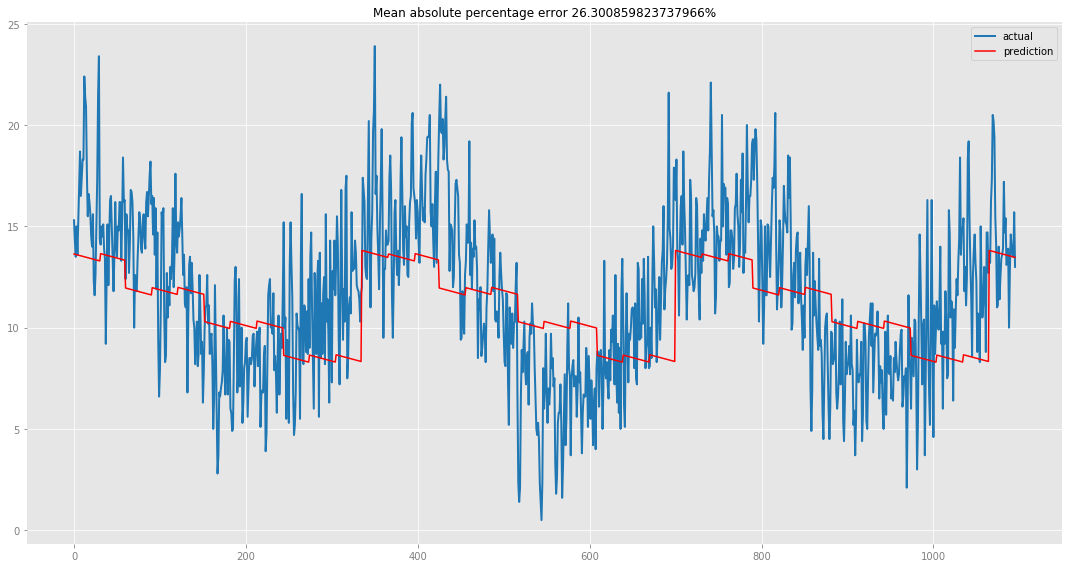

In [46]:
y = dataframe1.temperature
X = dataframe1.drop(['temperature'], axis=1)

machine_learning(lr, X,y)

As expected, *this model works better*, although it still needs a good deal of optimization.

Date-time based features are a good start, but it is often a lot more useful to **include the values at previous time steps**. These are called **lagged values** and we will look at adding these features in the next section.

### Lag Features

Lag features are the **classical way** that time series forecasting problems are transformed into supervised learning problems.

The simplest approach is to predict the value at the next time `(t)` given the value at the previous time `(t-1)`. The supervised learning problem with shifted values looks as follows:
```
Value(t-1), Value(t)
Value(t-1), Value(t)
Value(t-1), Value(t)
```

In [47]:
def lag_feats(dataframe, start, end, step):

    for i in range(start, end+1, step):
        dataframe["lag_{}".format(i)] = dataframe.Temp.shift(i)

Of course, this function allows this to be done **for any lag values**, but we are going to start simple and use only the **previous value**.

In [48]:
dataframe2 = temp_df.copy()
lag_feats(dataframe2, 1, 1, 1)

dataframe2.head()

,Temp,lag_1
Date,,
1981-01-01,20.7,NaN
1981-01-02,17.9,20.7
1981-01-03,18.8,17.9
1981-01-04,14.6,18.8
1981-01-05,15.8,14.6


As we can see, now the first row does not have enough information and **has to be discarded**.

In [49]:
dataframe2 = dataframe2.dropna()

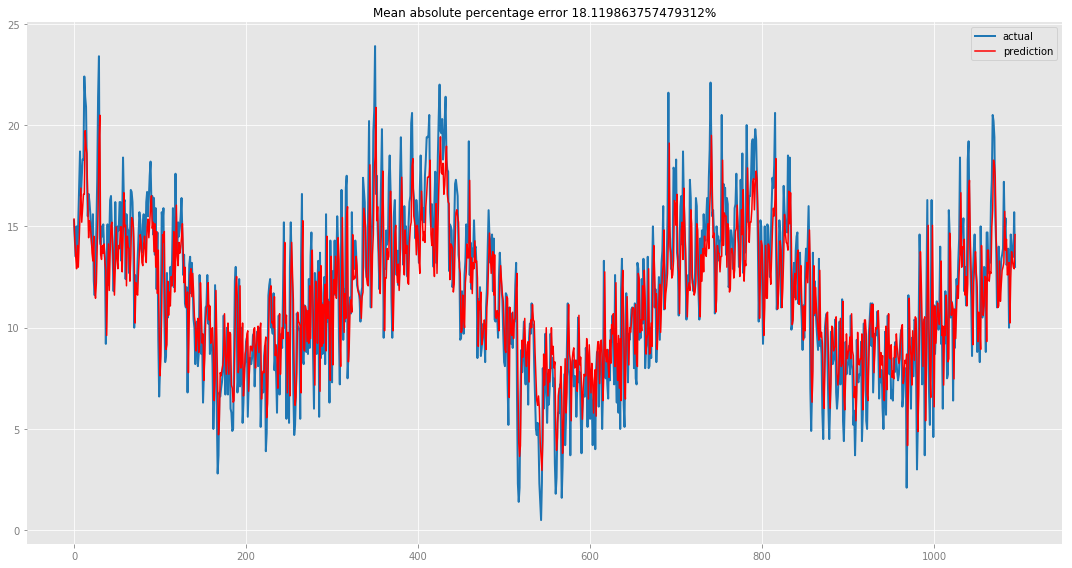

In [50]:
y = dataframe2.Temp
X = dataframe2.drop(['Temp'], axis=1)

machine_learning(lr, X,y)

This method has cut our error by *40%*!<br>
By using **more than one (continuous) lag features**, we are implementing a method called Sliding Window. We are essentially **sliding our focus along the time series** for each observation with an interest in only what is within the window width.<br>
What happens if we **increase the window size**?

In [51]:
dataframe3 = temp_df.copy()
lag_feats(dataframe3, 1, 6, 1)

dataframe3.head()

,Temp,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
Date,,,,,,,
1981-01-01,20.7,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,17.9,20.7,NaN,NaN,NaN,NaN,NaN
1981-01-03,18.8,17.9,20.7,NaN,NaN,NaN,NaN
1981-01-04,14.6,18.8,17.9,20.7,NaN,NaN,NaN
1981-01-05,15.8,14.6,18.8,17.9,20.7,NaN,NaN


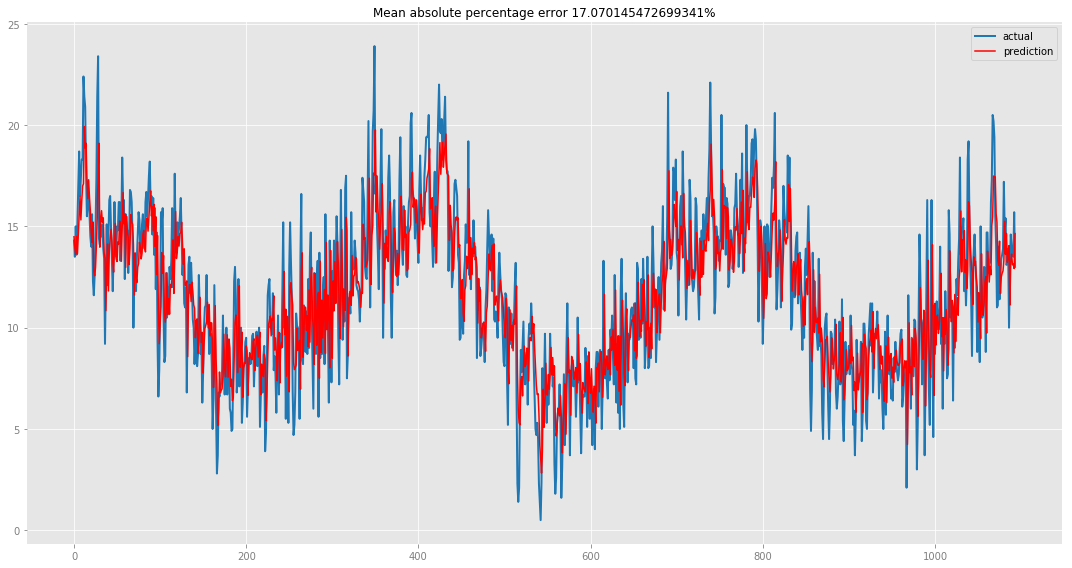

In [52]:
dataframe3 = dataframe3.dropna()

y = dataframe3.Temp
X = dataframe3.drop(['Temp'], axis=1)

machine_learning(lr, X,y)

We got even better results. Lets experiment with **changing the lag window starting position**.

In [53]:
dataframe4 = temp_df.copy()
lag_feats(dataframe4, 5, 15, 1)

dataframe4.head()

,Temp,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
Date,,,,,,,,,,,,
1981-01-01,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,17.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-04,14.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-05,15.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


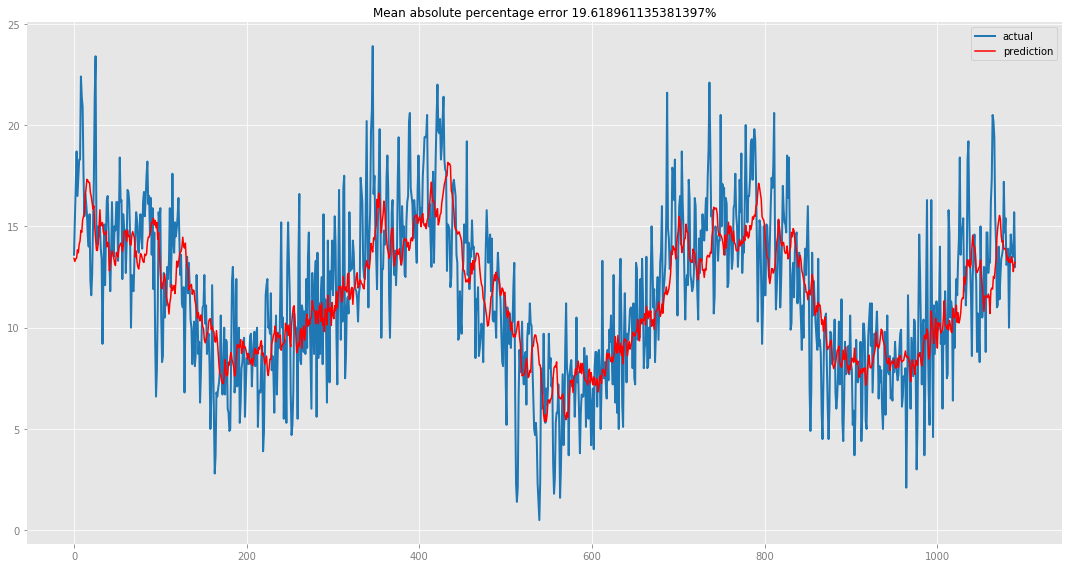

In [54]:
dataframe4 = dataframe4.dropna()

y = dataframe4.Temp
X = dataframe4.drop(['Temp'], axis=1)

machine_learning(lr, X,y)

We can thus see that the start of the window is also a factor that can *affect our model*.<br>
Also, why settle for linear windows? For our temperature dataset, maybe the best solution is looking at the temperature on the **same day up to 3 years ago**.

In [55]:
dataframe5 = temp_df.copy()
lag_feats(dataframe5, 1, 1096, 365)
dataframe5.head()

,Temp,lag_1,lag_366,lag_731,lag_1096
Date,,,,,
1981-01-01,20.7,NaN,NaN,NaN,NaN
1981-01-02,17.9,20.7,NaN,NaN,NaN
1981-01-03,18.8,17.9,NaN,NaN,NaN
1981-01-04,14.6,18.8,NaN,NaN,NaN
1981-01-05,15.8,14.6,NaN,NaN,NaN


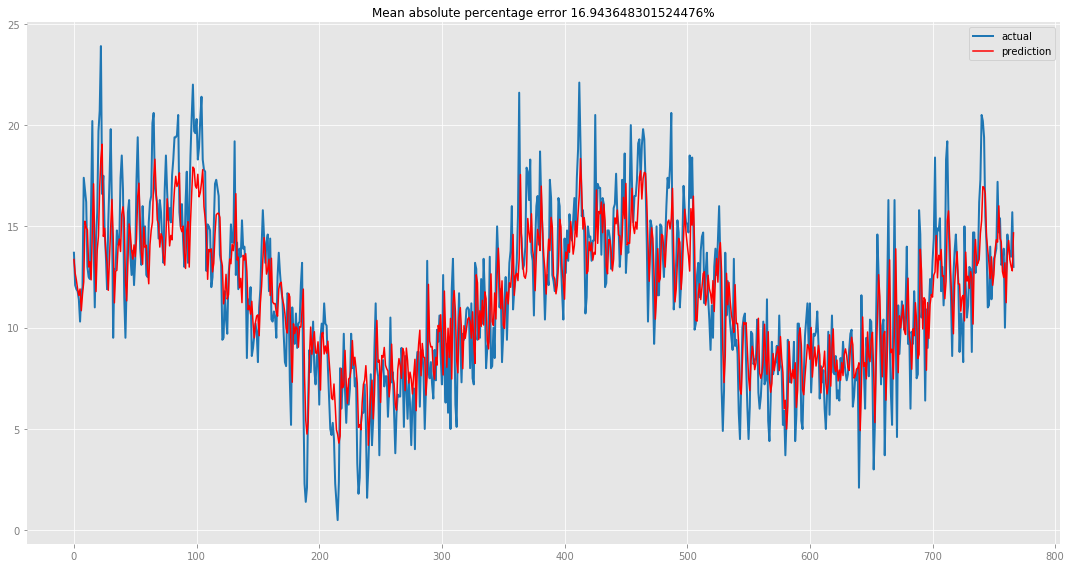

In [56]:
dataframe5 = dataframe5.dropna()

y = dataframe5.Temp
X = dataframe5.drop(['Temp'], axis=1)

machine_learning(lr, X,y)

Although we now **dropped a lot of data**, the accuracy is **still better** than previous models.<br>
The **main problem** that needs to be solved for Lag Features is the **size of the window**. In order to find an optimal size, either very **good domain knowledge** or a lot of trial and error is needed and, of course, the process can be automated using **cross validation**.

We can do more with a window than include the raw values. In the next section, we’ll look at including features that summarize statistics across the window.

### Window Features

A step beyond adding raw lagged values is to **add a summary of the values at previous time steps**. <br>
We can calculate summary **statistics** across the values in the sliding window and include these as features in our dataset. Perhaps **the most useful is the mean** of the previous few values, also called the **rolling mean** (or moving-rolling average).

For example, we can use two previous values to predict the next one:
```
mean(t-2, t-1)    t
----------------------
mean(20.7, 17.9)  18.8
    19.3          18.8
```

In [57]:
def rolling_mean(series, width):
    rolling_mean = series.rolling(window=width).mean()
    
    dataframe = pd.concat([rolling_mean, series], axis=1)
    dataframe.columns = ['mean(window={})'.format(width), 'y']
    
    return dataframe

This function implements this idea for any window size. Let's start with 2.

In [58]:
dataframe6 = rolling_mean(temp_series, 2)
dataframe6.head()

,mean(window=2),y
Date,,
1981-01-01,NaN,20.7
1981-01-02,19.30,17.9
1981-01-03,18.35,18.8
1981-01-04,16.70,14.6
1981-01-05,15.20,15.8


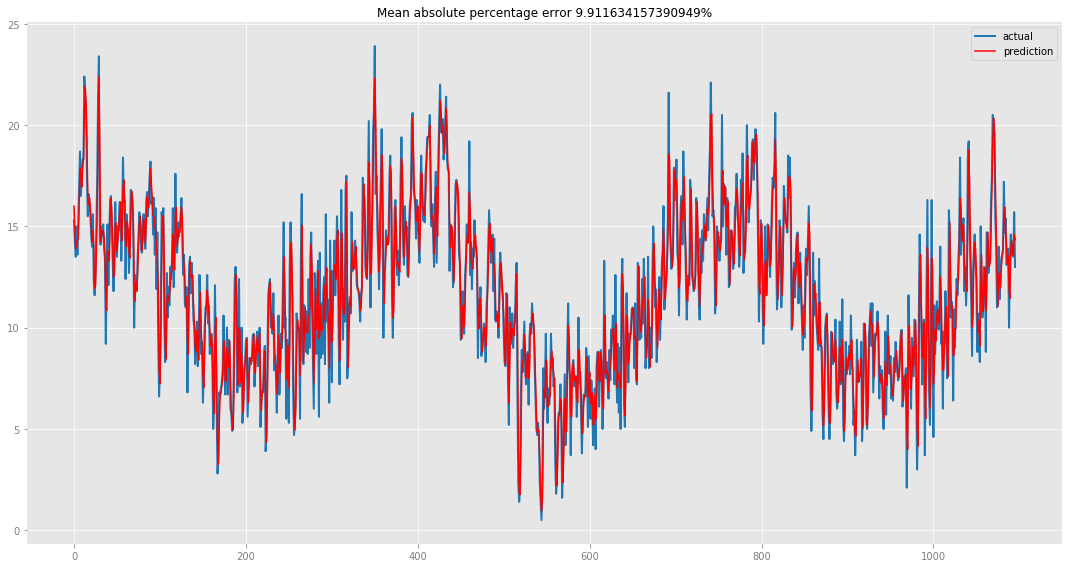

In [59]:
dataframe6 = dataframe6.dropna()

y = dataframe6.y
X = dataframe6.drop(['y'], axis=1)

machine_learning(lr, X,y)

This method almost *halved the error* again. Now experiment with **different window sizes**.

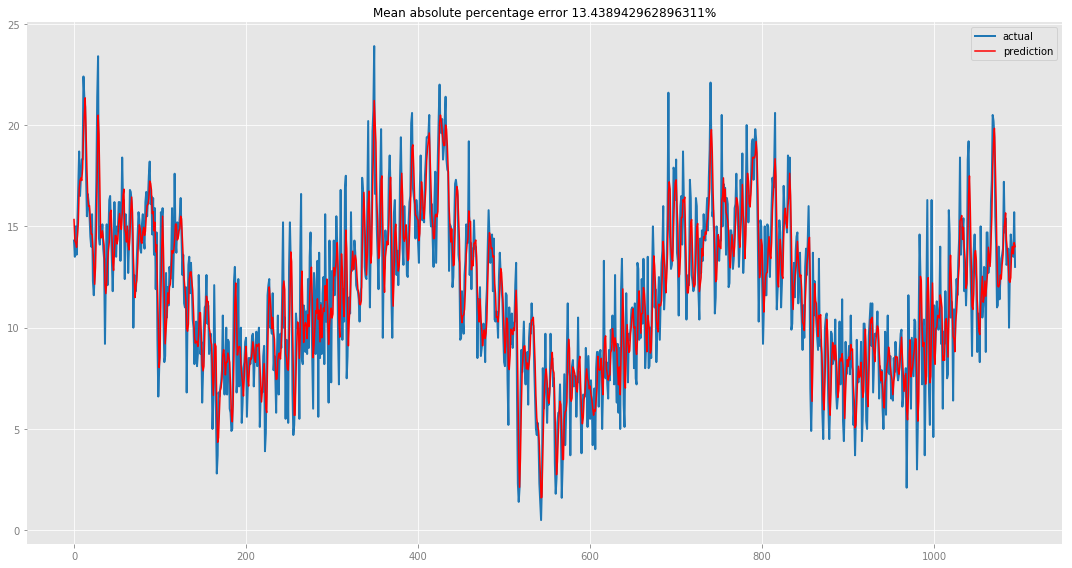

In [60]:
dataframe7 = rolling_mean(temp_series, 3)

dataframe7 = dataframe7.dropna()

y = dataframe7.y
X = dataframe7.drop(['y'], axis=1)

machine_learning(lr, X,y)

We can see that by *increasing the window size*, we *increase the error*.<br>
Appart from mean, we can also calculate other stats for our window.

In [61]:
def rolling_stats(series, width):
    rolling_mean = series.rolling(window=width).mean()
    rolling_max = series.rolling(window=width).max()
    #rolling_min = series.rolling(window=width).min()
    rolling_std = series.rolling(window=width).std()
    
    dataframe = pd.concat([rolling_mean, rolling_max, rolling_std, series], axis=1)
    dataframe.columns = ['mean', 'max', 'std', 'y']
    
    return dataframe

In [62]:
dataframe8 = rolling_stats(temp_series, 2)
dataframe8.head()

,mean,max,std,y
Date,,,,
1981-01-01,NaN,NaN,NaN,20.7
1981-01-02,19.30,20.7,1.979899,17.9
1981-01-03,18.35,18.8,0.636396,18.8
1981-01-04,16.70,18.8,2.969848,14.6
1981-01-05,15.20,15.8,0.848528,15.8


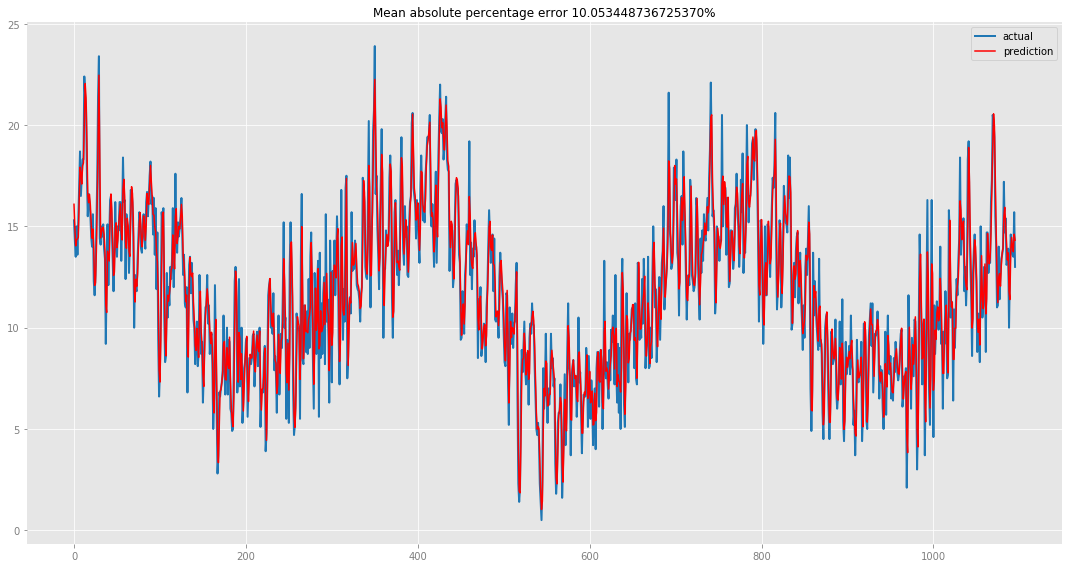

In [63]:
dataframe8 = dataframe8.dropna()

y = dataframe8.y
X = dataframe8.drop(['y'], axis=1)

machine_learning(lr, X,y)

Different statistics can provide different results.

Another type of window that may be useful **includes all previous data in the series**.<br>
This is called an **Expanding Window** and can help with keeping track of the bounds of observable data.

In [64]:
def expanding_stats(series):
    
    expanding_mean = series.expanding().mean()
    expanding_max = series.expanding().max()
    #expanding_min = series.expanding().min()
    expanding_std = series.expanding().std()
    
    dataframe = pd.concat([expanding_mean, expanding_max, expanding_std, series], axis=1) 
    dataframe.columns = ['mean', 'max', 'std', 'y'] 
    
    return dataframe

In [65]:
dataframe9 = expanding_stats(temp_series)
dataframe9.head()

,mean,max,std,y
Date,,,,
1981-01-01,20.700000,20.7,NaN,20.7
1981-01-02,19.300000,20.7,1.979899,17.9
1981-01-03,19.133333,20.7,1.429452,18.8
1981-01-04,18.000000,20.7,2.549510,14.6
1981-01-05,17.560000,20.7,2.417230,15.8


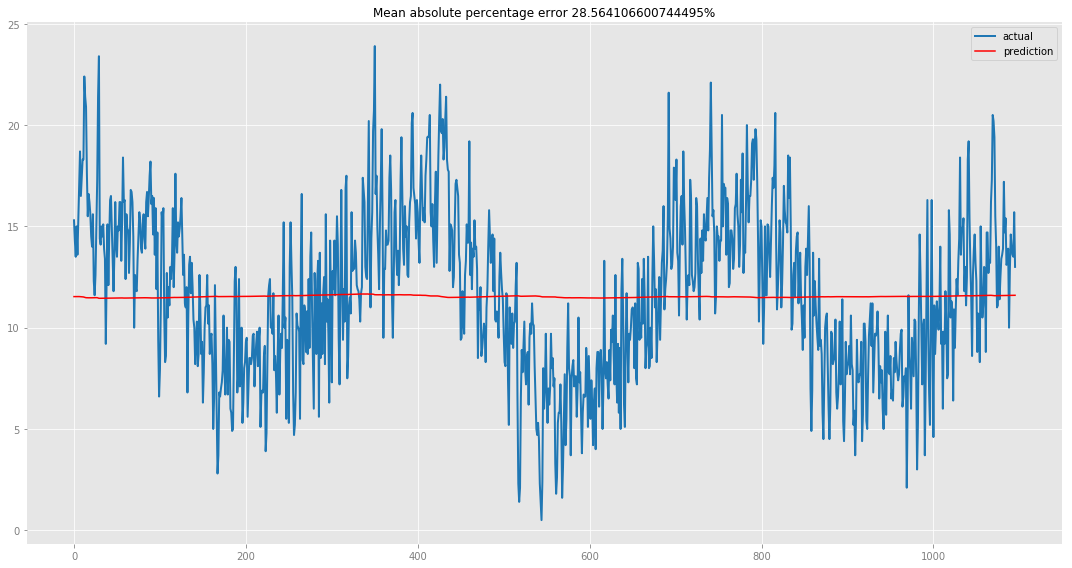

In [66]:
dataframe9 = dataframe9.dropna()

y = dataframe9.y
X = dataframe9.drop(['y'], axis=1)

machine_learning(lr, X,y)

An expanding window is a *bad idea* for temperature data, as **temperatures are stationary** and tend to have a mean value over time.

For the end, lets combine our two best models of lag and window features.

In [67]:
dataframe3.index = pd.to_datetime(dataframe3.index)

In [68]:
dataframe10 = pd.merge(dataframe3, dataframe8, on='Date')
dataframe10 = dataframe10.drop(['Temp'], axis=1)
dataframe10.head(10)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,mean,max,std,y
Date,,,,,,,,,,
1981-01-07,15.8,15.8,14.6,18.8,17.9,20.7,15.80,15.8,0.000000,15.8
1981-01-08,15.8,15.8,15.8,14.6,18.8,17.9,16.60,17.4,1.131371,17.4
1981-01-09,17.4,15.8,15.8,15.8,14.6,18.8,19.60,21.8,3.111270,21.8
1981-01-10,21.8,17.4,15.8,15.8,15.8,14.6,20.90,21.8,1.272792,20.0
1981-01-11,20.0,21.8,17.4,15.8,15.8,15.8,18.10,20.0,2.687006,16.2
1981-01-12,16.2,20.0,21.8,17.4,15.8,15.8,14.75,16.2,2.050610,13.3
1981-01-13,13.3,16.2,20.0,21.8,17.4,15.8,15.00,16.7,2.404163,16.7
1981-01-14,16.7,13.3,16.2,20.0,21.8,17.4,19.10,21.5,3.394113,21.5
1981-01-15,21.5,16.7,13.3,16.2,20.0,21.8,23.25,25.0,2.474874,25.0


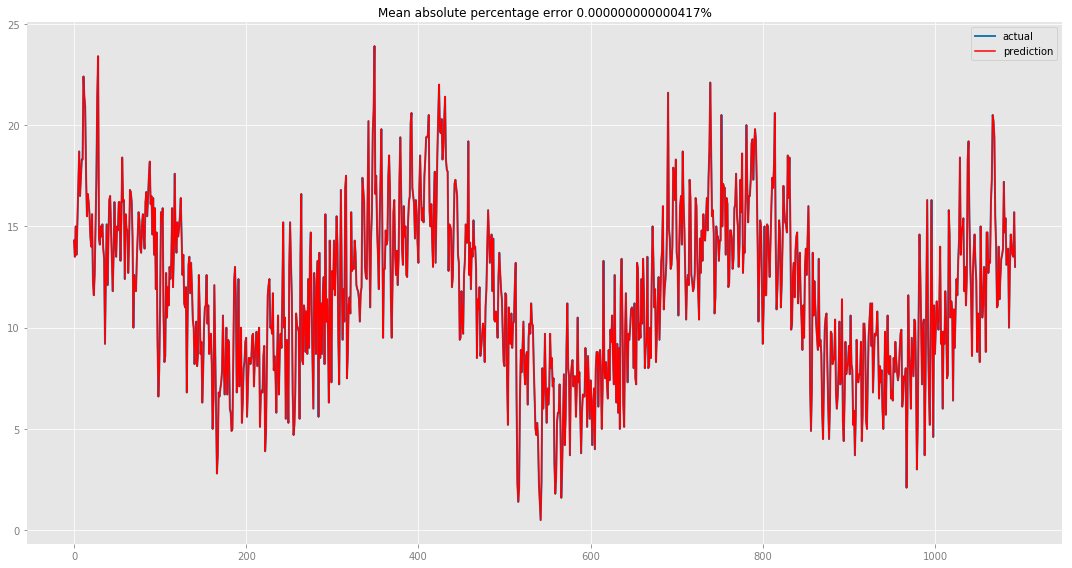

In [69]:
dataframe10 = dataframe10.dropna()

y = dataframe10.y
X = dataframe10.drop(['y'], axis=1)

machine_learning(lr, X,y)

This model nails it and has almost perfect accuracy. 

#### Advanced Features
Although (as we can see) we can predict accurately even with simple statistics features, some projects may require more **complex relationships**. Some examples could be:
- Arithmetical analysis features (for example the result of different splines)
- Signal Processing features (for example different filters)
- Mathematical features (for example local minima or maxima)

## Sources

Some tutorials that helped me learn more about time series and I used in order to create this tutorial:

- www.machinelearningplus.com/time-series/time-series-analysis-python/
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
- https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
- https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python